# Start of Notebook - LightGBM Flight Delay Training

This notebook trains LightGBM models using the dedicated `lightgbm_flight_pipeline.py`. We'll focus on training an LGBMClassifier for Binary Classification.

In [ ]:
# install packages if needed; colab has all of these though
# !pip install lightgbm joblib pandas numpy scikit-learn

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
import sys
import importlib
from google.colab import drive
from pprint import pprint
import datetime
import pickle
#  mount google drive
drive.mount('/content/drive', force_remount=True)

# set project path
project_path = '/content/drive/My Drive/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

# import the LightGBM pipeline
import pipeline_lgbm
importlib.reload(pipeline_lgbm)
from pipeline_lgbm import (
    train_lightgbm_model,
    get_lgbm_pipeline,
    get_lightgbm_estimator,
    InferencePipeline
)

print("Successfully loaded LightGBM pipeline!")

Mounted at /content/drive
Successfully loaded LightGBM pipeline!


In [ ]:
# configure paths (dataset paths, model and result paths for saving)

mod = "added_delay_20251202_034422" # or "full_no_encoding", "1", "2" etc. for the smaller datasets
DATA_FILE_PATH = "/content/drive/My Drive/CIS 5200 Final Project/train_test_datasets/"
CHECKPOINT_DIR = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/"


X_train_path = DATA_FILE_PATH + f'X_train_{mod}.csv'
y_train_path = DATA_FILE_PATH + f'y_train_{mod}.csv'

X_test_path = DATA_FILE_PATH + f'X_test_{mod}.csv'
y_test_path = DATA_FILE_PATH + f'y_test_{mod}.csv'

# configure target variables
CLASS_TARGET = 'DEP_DEL15'

## Hyperparameter Tuning (Optional)

In [ ]:
!pip install optuna
!pip install optuna-integration[wandb]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import lightgbm as lgb
import numpy as np
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score
import wandb

def objective(trial, X_train, y_train, X_valid, y_valid, optimization_metric):
    """
    Optuna objective function for LGBMClassifier.
    Optimizes a specific metric while monitoring others.
    """

    # 1. Define Metrics
    # We always monitor these three for binary classification
    eval_metrics = ['binary_logloss', 'auc', 'average_precision']

    # 2. Define Hyperparameter Search Space
    # Ranges adapted for efficient tuning of tree structure and regularization
    params = {
        'objective': 'binary',
        'metric': eval_metrics,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,

        # Tree Structure
        'n_estimators': trial.suggest_int('n_estimators', 100, 7500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),

        # Regularization & Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),

        # Class Imbalance Handling
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0, step = 0.1),
    }

    # 3. Instantiate Model
    model = lgb.LGBMClassifier(**params)

    # 4. Pruning & Callbacks
    # Prune trials that are unpromising relative to the optimization_metric
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, optimization_metric)

    # Early stopping ensures we don't overfit or waste time on a plateau
    early_stopping = lgb.early_stopping(stopping_rounds=100, verbose=False)
    log_evaluation = lgb.log_evaluation(period=0) # Silence logs during tuning to keep output clean

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=eval_metrics,
        callbacks=[pruning_callback, early_stopping, log_evaluation]
    )

    # 5. Return Score
    # Predict probabilities for evaluation
    preds = model.predict_proba(X_valid)[:, 1]

    if optimization_metric == 'auc':
        return roc_auc_score(y_valid, preds)
    elif optimization_metric == 'binary_logloss':
        return log_loss(y_valid, preds)
    elif optimization_metric == 'average_precision':
        return average_precision_score(y_valid, preds)

    return 0.0

def run_optuna_tuning(
    X, y,
    optimization_metric='binary_logloss',
    n_trials=50,
    valid_size=0.2,
    study_name='lgbm_classification_study',
    wandb_project='flight_delay_project',
    save_dir='./',
    random_state=42
):
    """
    Main tuning function.
    Splits data, runs Optuna with W&B, and saves best parameters.
    """

    # 0. Handle Categorical Features (Fix for "pandas dtypes must be int, float or bool")
    # LightGBM requires categorical features to be of type 'category', not 'object'
    if hasattr(X, 'select_dtypes'):
        object_cols = X.select_dtypes(include=['object']).columns
        if len(object_cols) > 0:
            print(f"Converting object columns to 'category' dtype for LightGBM: {list(object_cols)}")
            X = X.copy()
            for col in object_cols:
                X[col] = X[col].astype('category')

    # 1. Validation Split (Fixed for all trials)
    print(f"Splitting data (valid_size={valid_size})...")
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=valid_size, random_state=random_state, stratify=y
    )
    print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}")

    # 2. W&B Integration
    wandb_kwargs = {"project": wandb_project, "group": "LGBM_Classifier_Tuning"}
    wandbc = WeightsAndBiasesCallback(metric_name="value", wandb_kwargs=wandb_kwargs)

    # 3. Create Study
    # Direction depends on metric (AUC/AUPRC = Maximize, LogLoss = Minimize)
    direction = 'maximize' if optimization_metric in ['auc', 'average_precision'] else 'minimize'

    study = optuna.create_study(
        direction=direction,
        study_name=study_name,
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10, n_startup_trials=5)
    )

    print(f"Starting Optuna optimization for {optimization_metric}...")

    try:
        study.optimize(
            lambda trial: objective(
                trial,
                X_train, y_train,
                X_valid, y_valid,
                optimization_metric
            ),
            n_trials=n_trials,
            callbacks=[wandbc]
        )
    except KeyboardInterrupt:
        print("Tuning interrupted by user! Saving current best results...")

    # 4. Results & Saving
    print("\nOptimization Complete.")
    print(f"Best Trial Value ({optimization_metric}): {study.best_value}")
    print("Best Params:", study.best_params)

    # Save best params to JSON
    save_path = os.path.join(save_dir, f"best_params_{study_name}.json")
    with open(save_path, 'w') as f:
        json.dump(study.best_params, f, indent=4)

    print(f"Best hyperparameters saved to: {save_path}")

    return study

In [ ]:
# 2. Prepare Data
# Load your dataset (assuming you have your X_train and y_train ready)
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)[CLASS_TARGET]

X_tune, _, y_tune, _ = train_test_split(
    X_train,
    y_train,
    train_size=250000,  # Or use a float like 0.1 for 10%
    stratify=y_train,   # <--- CRITICAL
)

In [ ]:
# X_tune.drop(columns=['DEP_HOUR', # COLLINEAR WITH DEP_TIME
#     'DEP_TIME_BLK'], inplace=True)

KeyError: "['DEP_HOUR', 'DEP_TIME_BLK'] not found in axis"

In [ ]:
# 1. Login to W&B (Required)
wandb.login()

# -----------------------------

# 3. Run the Tuning
# This will:
# - Split the data 80/20
# - Run 200 trials optimizing for Binary Log Loss
# - Log everything to W&B
# - Save 'best_params_flight_delay_v1.json' to your current folder
study = run_optuna_tuning(
    X=X_tune,
    y=y_tune,
    optimization_metric='binary_logloss', # Options: 'binary_logloss', 'auc', 'average_precision'
    n_trials=200,
    valid_size=0.2,
    study_name='LightGBMClass Study',
    wandb_project='CIS_5200_Final_Project',
    save_dir=CHECKPOINT_DIR
)

# 4. Access Results Programmatically
print("Best params found:", study.best_params)
print("Best score:", study.best_value)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Converting object columns to 'category' dtype for LightGBM: ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE_NAME', 'INCOMING_ROUTE', 'CARRIER_AIRPORT']
Splitting data (valid_size=0.2)...
Train shape: (200000, 47), Valid shape: (50000, 47)


/tmp/ipython-input-3091020163.py:114: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="value", wandb_kwargs=wandb_kwargs)


colsample_bytree,▁▄█▇▄▃▇▂█▇▁
learning_rate,▇▃▄▄▁▇▄▁▆▃█
max_depth,▄▅▁▇▂▄▇▅▅█▃
min_child_samples,▅▇▄█▂█▂▂▁▅▅
n_estimators,▅█▇▃▆█▃▄▇▄▁
num_leaves,▆█▅▄▁█▂▆▇▅▃
reg_alpha,▁█▁▁▁▂▁▇▁▁▁
reg_lambda,▁▁▁▅▁▁▅▁█▁▁
scale_pos_weight,▁▃▅█▄▅▂▃▅▃▁
subsample,▃▆▂▁▇█▁▄▄█▃
+2,...


[I 2025-12-02 17:04:58,215] A new study created in memory with name: LightGBMClass Study


Starting Optuna optimization for binary_logloss...


[I 2025-12-02 17:05:04,259] Trial 0 finished with value: 0.4434096007950865 and parameters: {'n_estimators': 500, 'learning_rate': 0.04, 'num_leaves': 230, 'max_depth': 5, 'min_child_samples': 35, 'subsample': 0.65, 'subsample_freq': 2, 'colsample_bytree': 0.62, 'reg_alpha': 6.77301797464896, 'reg_lambda': 0.0046264713499418585, 'scale_pos_weight': 2.1}. Best is trial 0 with value: 0.4434096007950865.
[I 2025-12-02 17:05:12,461] Trial 1 finished with value: 0.4577452086787077 and parameters: {'n_estimators': 300, 'learning_rate': 0.11, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8, 'subsample_freq': 2, 'colsample_bytree': 0.65, 'reg_alpha': 0.0012515706354240866, 'reg_lambda': 1.3187685788070676e-07, 'scale_pos_weight': 9.6}. Best is trial 0 with value: 0.4434096007950865.
[I 2025-12-02 17:05:17,166] Trial 2 finished with value: 0.4571750779670553 and parameters: {'n_estimators': 1700, 'learning_rate': 0.02, 'num_leaves': 150, 'max_depth': 3, 'min_child_s


Optimization Complete.
Best Trial Value (binary_logloss): 0.40678460118057336
Best Params: {'n_estimators': 6700, 'learning_rate': 0.08, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 82, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.96, 'reg_alpha': 1.2772058535864914e-07, 'reg_lambda': 1.112481267885558e-06, 'scale_pos_weight': 1.0}
Best hyperparameters saved to: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/best_params_LightGBMClass Study.json
Best params found: {'n_estimators': 6700, 'learning_rate': 0.08, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 82, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.96, 'reg_alpha': 1.2772058535864914e-07, 'reg_lambda': 1.112481267885558e-06, 'scale_pos_weight': 1.0}
Best score: 0.40678460118057336


## SKLearn RandomizedSearch approach
We tune `num_leaves` and `learning_rate` on a subset of data using standard Cross Validation.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# 1. Load Subset for Tuning (100k rows)
X_tune = pd.read_csv(X_train_path, nrows=100000)
y_tune = pd.read_csv(y_train_path, nrows=100000)[CLASS_TARGET]

# 2. Build Tuning Pipeline
# We keep n_jobs=-1 in the model so it uses all cores for training
lgbm_estimator = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss', # Monitor log loss internally
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
prep_pipeline = get_lgbm_pipeline()

full_tune_pipeline = Pipeline(steps=[
    ('prep', prep_pipeline),
    ('model', lgbm_estimator)
])

# 3. Define Parameter Grid
param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500, 750, 1000],
    'model__num_leaves': [31, 50, 70, 100],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__scale_pos_weight': [1, 3, 5, 6, 10], # Helps with class imbalance (delayed flights are rare)
}
scoring = {'Log Loss': 'neg_log_loss', 'AUC': 'roc_auc', 'F1 Score': 'f1',
           'Precision': 'precision', 'Recall': 'recall'}
refit = 'Log Loss'
# 4. Run Search (Optimizing for AUC)
search = RandomizedSearchCV(
    estimator=full_tune_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring=scoring, # Metrics for classification
    refit=refit, # refit on this metric
    n_jobs=1,          # Prevent deadlock
    verbose=3
)

print("Starting Hyperparameter Search...")
results = search.fit(X_tune, y_tune)

Starting Hyperparameter Search...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END model__colsample_bytree=0.6, model__learning_rate=0.07, model__n_estimators=100, model__num_leaves=31, model__scale_pos_weight=10, model__subsample=1.0; AUC: (test=0.684) F1 Score: (test=0.341) Log Loss: (test=-0.839) Precision: (test=0.212) Recall: (test=0.863) total time=   1.5s
[CV 2/3] END model__colsample_bytree=0.6, model__learning_rate=0.07, model__n_estimators=100, model__num_leaves=31, model__scale_pos_weight=10, model__subsample=1.0; AUC: (test=0.681) F1 Score: (test=0.341) Log Loss: (test=-0.843) Precision: (test=0.212) Recall: (test=0.864) total time=   1.4s
[CV 3/3] END model__colsample_bytree=0.6, model__learning_rate=0.07, model__n_estimators=100, model__num_leaves=31, model__scale_pos_weight=10, model__subsample=1.0; AUC: (test=0.688) F1 Score: (test=0.342) Log Loss: (test=-0.840) Precision: (test=0.213) Recall: (test=0.875) total time=   1.4s
[CV 1/3] END model__

In [ ]:
print(f"Best Params: {search.best_params_}")
print(f"Best Log Loss: {-search.best_score_}") # Negate because sklearn uses negative log loss

Best Params: {'model__subsample': 0.6, 'model__scale_pos_weight': 1, 'model__num_leaves': 50, 'model__n_estimators': 400, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.6}
Best Log Loss: 0.4261688856906747


### Save hyperparam results

In [ ]:
# save dictionary with timestamp in name for safe saving

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = CHECKPOINT_DIR + f"lgbm_class_hyperparam_sweep_results_{timestamp}.pkl"

with open(results_path, 'wb') as f:
    pickle.dump(results, f)


In [ ]:
# load results from pickle file
results_name = 'lgbm_class_hyperparam_sweep_results_20251130_030527.pkl'
with open(CHECKPOINT_DIR + results_name, 'rb') as f:
    results = pickle.load(f)
results = results.cv_results_

In [ ]:
# results

In [ ]:
for metric in scoring:
  metric_best_params = results['params'][np.argmin(results[f'rank_test_{metric}'])]
  metric_best_score = results[f'mean_test_{metric}'][np.argmin(results[f'rank_test_{metric}'])]
  print(f"Best Params ({metric}): {metric_best_params}")
  if metric == 'Log Loss':
    print(f"Best {metric} (Validation): {-metric_best_score}")
  else:
    print(f"Best {metric} (Validation): {metric_best_score}")
  print('=' * 50)


Best Params (Log Loss): {'model__subsample': 0.6, 'model__scale_pos_weight': 1, 'model__num_leaves': 50, 'model__n_estimators': 400, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.6}
Best Log Loss (Validation): 0.4261688856906747
Best Params (AUC): {'model__subsample': 0.6, 'model__scale_pos_weight': 1, 'model__num_leaves': 50, 'model__n_estimators': 400, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.6}
Best AUC (Validation): 0.6897637789207208
Best Params (F1 Score): {'model__subsample': 0.8, 'model__scale_pos_weight': 5, 'model__num_leaves': 31, 'model__n_estimators': 500, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}
Best F1 Score (Validation): 0.3731204667022108
Best Params (Precision): {'model__subsample': 0.6, 'model__scale_pos_weight': 1, 'model__num_leaves': 70, 'model__n_estimators': 100, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Best Precision (Validation): 0.5591108801147064
Best Params (Recall): {'model__subsample

## Train Binary Classificatoin Model
Uses the custom training loop with **Early Stopping**.

In [ ]:
# --- CONFIGURATION ---
best_logloss_params = {'subsample': 0.6, 'scale_pos_weight': 1.2, 'num_leaves': 50,
                       'learning_rate': 0.03, 'colsample_bytree': 0.6, 'n_estimators': 5000}
# best_logloss_params = {'subsample': 0.6, 'model__scale_pos_weight': 1, 'model__num_leaves': 50,
#  'n_estimators': 400, 'learning_rate': 0.03, 'model__colsample_bytree': 0.6}
# best_optuna_trial_params = {'n_estimators': 968, # 'n_estimators': 5000,
#                             'learning_rate': 0.16485981295339067, # 'learning_rate': 0.03,
#                             'num_leaves': 90, 'max_depth': 15,
#                             'min_child_samples': 44,
#                             'subsample': 0.9964487244487961,
#                             'subsample_freq': 1,
#                             'colsample_bytree': 0.5932732460674595,
#                             'reg_alpha': 0.0015660554786847344,
#                             'reg_lambda': 0.0002374094843853652,
#                             'scale_pos_weight': 1.246944358759853}

# used this for the first "added_delay_removed_dep_hour_time_blk" model.
# best_optuna_trial_params = {'n_estimators': 5000,
#                             'learning_rate': 0.03,
#                             'num_leaves': 90, 'max_depth': 15,
#                             'min_child_samples': 44,
#                             'subsample': 0.6,
#                             'colsample_bytree': 0.6,
#                             'reg_alpha': 0.0015660554786847344,
#                             'reg_lambda': 0.0002374094843853652,
#                             'scale_pos_weight': 1.246944358759853}

best_optuna_trial_params = {'n_estimators': 6700, 'learning_rate': 0.08,
                            'num_leaves': 190, 'max_depth': 15,
                            'min_child_samples': 82, 'subsample': 0.9,
                            'subsample_freq': 1, 'colsample_bytree': 0.96,
                            'reg_alpha': 1.2772058535864914e-07,
                            'reg_lambda': 1.112481267885558e-06,
                            'scale_pos_weight': 1.0}
stopping_rounds = 100 # threshold for early stopping (train until you don't improve for <- e.g. 100 rounds )
# Create Model Instance
# You can paste the best params from the previous cell here
class_model = get_lightgbm_estimator(
    model_type='classification',
    use_gpu=False, # Changed from True to False
    **best_optuna_trial_params # Unpack the dictionary to pass parameters directly
)

# 2. Train
results_class = train_lightgbm_model(
    model=class_model,
    X_train_path=X_train_path,
    y_train_path=y_train_path,
    X_test_path=X_test_path,
    y_test_path=y_test_path,
    model_type='classification',
    description="LGBM_Class_added_delay",
    stopping_rounds=stopping_rounds,
    checkpoint_dir=CHECKPOINT_DIR)

pprint(results_class)

  >> Configured for Binary Classification

--- Starting LightGBM Training: LGBM_Class_added_delay ---
  Loading Training Data...
  Creating Validation Split (15%)...
Stratifying validation set
  Preprocessing...
DROPPED FEATURES:
[]
DROPPED FEATURES:
[]
  Training classification (Early Stopping enabled)...
Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.169147	valid's auc: 0.966205	valid's average_precision: 0.906541
[200]	valid's binary_logloss: 0.154348	valid's auc: 0.971144	valid's average_precision: 0.917723
[300]	valid's binary_logloss: 0.145836	valid's auc: 0.973859	valid's average_precision: 0.924394
[400]	valid's binary_logloss: 0.140338	valid's auc: 0.975552	valid's average_precision: 0.928638
[500]	valid's binary_logloss: 0.137008	valid's auc: 0.976513	valid's average_precision: 0.931193
[600]	valid's binary_logloss: 0.13457	valid's auc: 0.977206	valid's average_precision: 0.933093
[700]	valid's binary_logloss: 0.132476	valid's au

## 6. Inference from Checkpoint
How to load a saved model later.

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
class_path = '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/'
# 1. Load
# chk_path = CHECKPOINT_DIR + 'LGBM_classification_LGBM_Class_10k_estim_1k_earlystop_20251130_050109.joblib'
# chk_path = CHECKPOINT_DIR + 'LGBM_classification_LGBM_Class_Baseline_20251130_033916.joblib'
# chk_path = CHECKPOINT_DIR + 'LGBM_classification_LGBM_Class_added_delay_20251202_063545.joblib'
chk_path = class_path +  'LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib'
# chk_path = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/LGBM_classification_LGBM_Class_added_delay_removed_dep_hour_time_blk_20251202_072903.joblib"
# chk_path = results_class['checkpoint_path'] # Or paste a string path
print(f"Loading: {chk_path}")
loaded_pipeline = joblib.load(chk_path)
model = loaded_pipeline.model
feature_names = model.feature_name_
importances = model.feature_importances_

Loading: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib


In [ ]:
# load model performance metrics from json file
import json

# results_path = class_path + "LGBM_classification_LGBM_Class_added_delay_removed_dep_hour_time_blk_20251202_072903_metrics.json"

# results_path = class_path +  'LGBM_classification_LGBM_Class_added_delay_no_collinear_20251202_054037_metrics.json'
# results_path = class_path + 'LGBM_classification_LGBM_Class_added_delay_20251202_063545_metrics.json'
results_path = class_path +  'LGBM_classification_LGBM_Class_added_delay_20251202_192444_metrics.json'
# results_path = results_class['metrics_path']
with open(results_path, 'r') as f:
    results = json.load(f)
pprint(results)

{'accuracy': 0.956201497960044,
 'auc': 0.8931896484228498,
 'average_precision/auprc': 0.784058267064066,
 'checkpoint_path': '/content/drive/My Drive/CIS 5200 Final '
                    'Project/models/lightGBM/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib',
 'confusion_matrix': [[1041152, 11187], [44507, 174750]],
 'description': 'LGBM_Class_added_delay',
 'f1': 0.8625497909643282,
 'model_type': 'classification',
 'parameters': {'boosting_type': 'gbdt',
                'class_weight': None,
                'colsample_bytree': 0.96,
                'importance_type': 'split',
                'learning_rate': 0.08,
                'max_depth': 15,
                'metric': ['binary_logloss', 'auc', 'average_precision'],
                'min_child_samples': 82,
                'min_child_weight': 0.001,
                'min_split_gain': 0.0,
                'n_estimators': 6700,
                'n_jobs': -1,
                'num_leaves': 190,
                'obje

Top 10 Features:
               Feature  Importance
22      INCOMING_ROUTE      102760
21          ROUTE_NAME       94149
2             DEP_TIME       71023
3         DEP_TIME_BLK       33969
29                AWND       27410
0                MONTH       26043
23     CARRIER_AIRPORT       25240
27                TMAX       23914
28                TMIN       23112
7   CONCURRENT_FLIGHTS       21601


/tmp/ipython-input-2086405352.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')


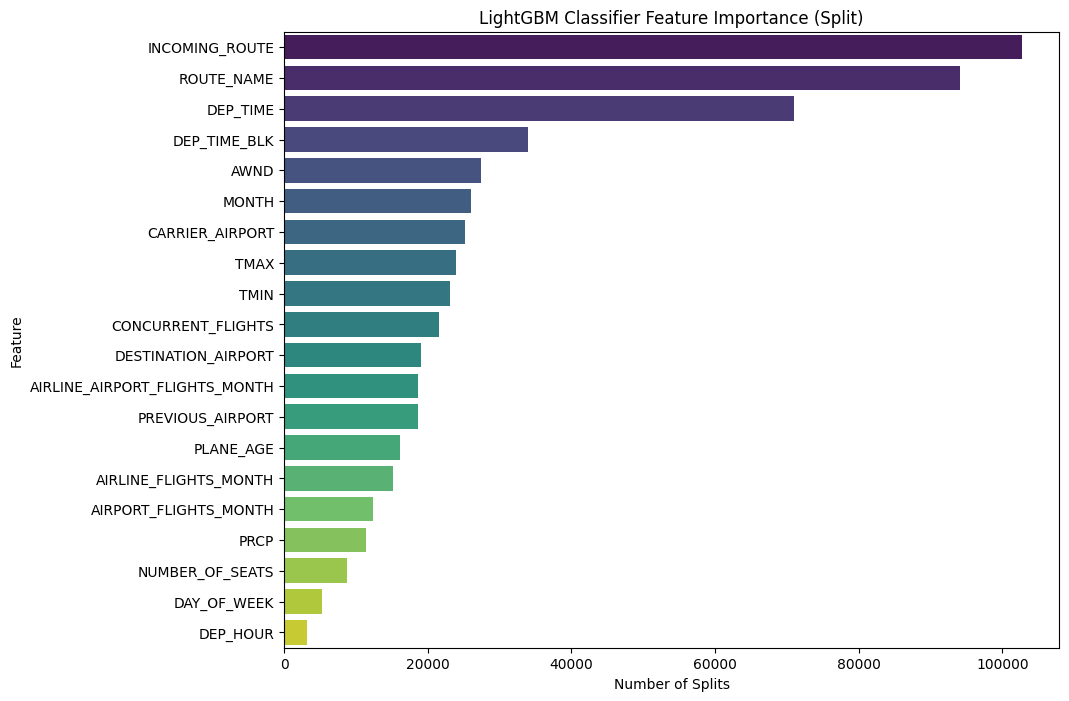

In [ ]:
# 3. Create a DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Print the Top 10 specific numbers you were seeing
print("Top 10 Features:")
print(df_importance.head(10))

# 5. Plot Top 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')
plt.title('LightGBM Classifier Feature Importance (Split)')
plt.xlabel('Number of Splits')
plt.show()

In [ ]:
len(loaded_pipeline.model.feature_importances_)


49

In [ ]:
# 2. Sample Data
df_sample = pd.read_csv(X_test_path, nrows=10)
y_sample = pd.read_csv(y_test_path, nrows=10)[CLASS_TARGET]

# count num misclassified
y_pred = loaded_pipeline.predict(df_sample)
num_misclassified = np.sum(y_pred != y_sample.values)
print(f"Number Correctly Classified: {len(df_sample)-num_misclassified}")
print(f"Number Misclassified: {num_misclassified}")
# 3. Predict
print("Sample Labels:", y_sample.values)
preds = loaded_pipeline.predict(df_sample)
print("Predictions:", preds)

Loading: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/LGBM_classification_LGBM_Class_10k_estim_1k_earlystop_20251130_050109.joblib
Number Correctly Classified: 8
Number Misclassified: 2
Sample Labels: [0 0 0 0 0 0 1 0 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0]
